In [ ]:
pip install 'shimmy>=0.2.1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.3.2 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0 which is incompatible.


In [ ]:
!pip install torch gym numpy pandas matplotlib

!pip install stable-baselines3 gym[atari,accept-rom-license]

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('supply_chain_data.csv')
print(data.head())

print(data.dtypes)

for column in data.columns:
    print(f"Unique values in '{column}': {data[column].unique()}")

data = pd.get_dummies(data, drop_first=True)

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

  Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai        29          

In [ ]:
import gym
from gym import spaces
import numpy as np

class SupplyChainEnv(gym.Env):
    def __init__(self):
        super(SupplyChainEnv, self).__init__()

        self.action_space = spaces.Discrete(10)
        self.observation_space = spaces.Box(low=0, high=1, shape=(normalized_data.shape[1],), dtype=np.float32)

        self.state = None
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        self.state = normalized_data[self.current_step]
        return self.state

    def step(self, action):
        reward = self._calculate_reward(action)
        self.current_step += 1

        if self.current_step >= len(normalized_data) - 1:
            done = True
        else:
            done = False
            self.state = normalized_data[self.current_step]

        return self.state, reward, done, {}

    def _calculate_reward(self, action):
        reward = -abs(action - self.state[0])
        return reward


In [ ]:
from stable_baselines3 import A2C, DQN
from stable_baselines3.common.env_util import make_vec_env
env = make_vec_env(lambda: SupplyChainEnv(), n_envs=4)

a2c_model = A2C('MlpPolicy', env, verbose=1)
a2c_model.learn(total_timesteps=10000)

dqn_model = DQN('MlpPolicy', env, verbose=1)
dqn_model.learn(total_timesteps=10000)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 99       |
|    ep_rew_mean        | -172     |
| time/                 |          |
|    fps                | 1120     |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -0.297   |
|    explained_variance | 0.0996   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.709    |
|    value_loss         | 162      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 99       |
|    ep_rew_mean        | -114     |
| time/                 |          |
|    fps                | 797      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 4000     |
| train/                |          |
|

In [ ]:
import numpy as np

def evaluate_model(model, env, num_episodes=100):
    total_rewards = []
    episode_lengths = []

    for episode in range(num_episodes):
        obs = env.reset()
        done = np.zeros(env.num_envs, dtype=bool)
        total_reward = 0
        episode_length = 0

        while not np.all(done):  S
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)

            total_reward += reward.sum()
            episode_length += 1


            for idx in range(len(done)):
                if done[idx]:
                    obs[idx] = env.reset()[idx]

        total_rewards.append(total_reward)
        episode_lengths.append(episode_length)

        print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {total_reward}, Episode Length: {episode_length}")

    avg_reward = np.mean(total_rewards)
    avg_length = np.mean(episode_lengths)

    print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    print(f"Average Episode Length over {num_episodes} episodes: {avg_length}")


evaluate_model(dqn_model, env, num_episodes=100)


evaluate_model(a2c_model, env, num_episodes=100)


Episode 1/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 2/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 3/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 4/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 5/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 6/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 7/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 8/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 9/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 10/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 11/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 12/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 13/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 14/100 - Total Reward: -118.74789202702232, Episode Length: 99
Episode 15/100 

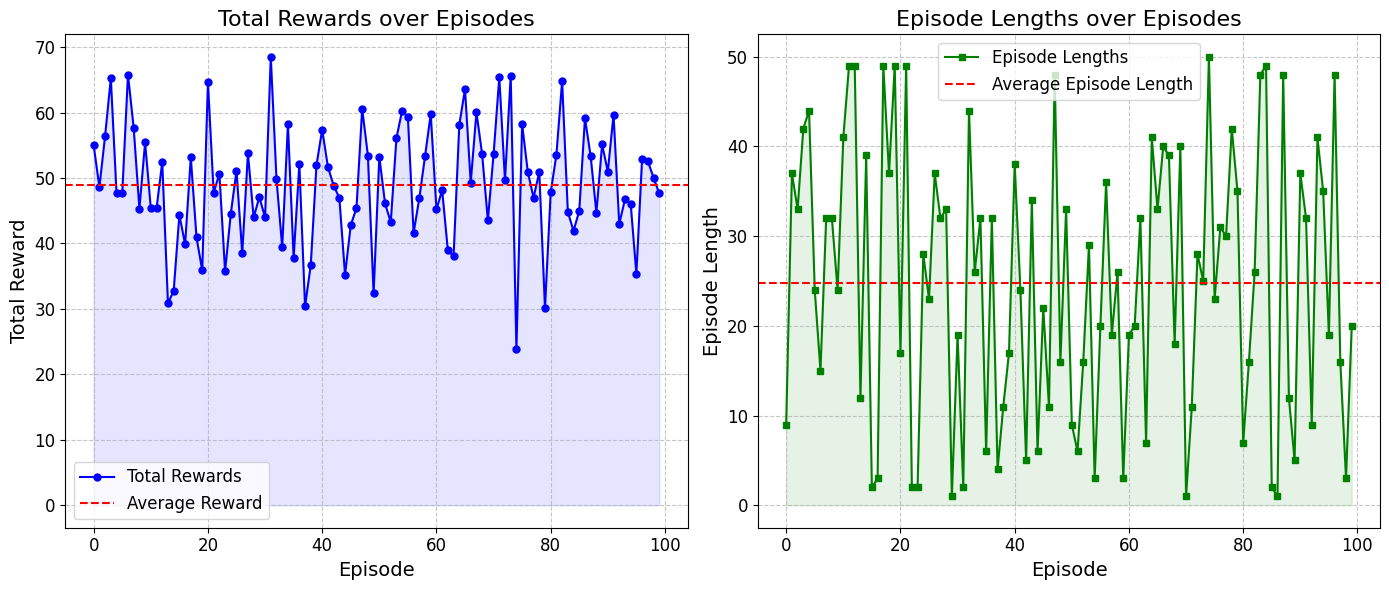

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot_model(model, env, num_episodes=100):
    total_rewards = []
    episode_lengths = []

    for episode in range(num_episodes):
        obs = env.reset()
        done = np.zeros(env.num_envs, dtype=bool)
        total_reward = 0
        episode_length = 0

        while not np.all(done):
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)

            total_reward += reward.sum()
            episode_length += 1


            for idx in range(len(done)):
                if done[idx]:
                    obs[idx] = env.reset()[idx]

        total_rewards.append(total_reward)
        episode_lengths.append(episode_length)

    avg_reward = np.mean(total_rewards)
    avg_length = np.mean(episode_lengths)


    plt.figure(figsize=(14, 6))


    plt.subplot(1, 2, 1)
    plt.plot(total_rewards, marker='o', color='blue', linestyle='-', markersize=5, label='Total Rewards')
    plt.axhline(y=avg_reward, color='red', linestyle='--', label='Average Reward')
    plt.title('Total Rewards over Episodes', fontsize=16)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Total Reward', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between(range(num_episodes), 0, total_rewards, color='blue', alpha=0.1)
    plt.legend(fontsize=12)


    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths, marker='s', color='green', linestyle='-', markersize=5, label='Episode Lengths')
    plt.axhline(y=avg_length, color='red', linestyle='--', label='Average Episode Length')
    plt.title('Episode Lengths over Episodes', fontsize=16)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Episode Length', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between(range(num_episodes), 0, episode_lengths, color='green', alpha=0.1)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


evaluate_and_plot_model(dqn_model, env, num_episodes=100)




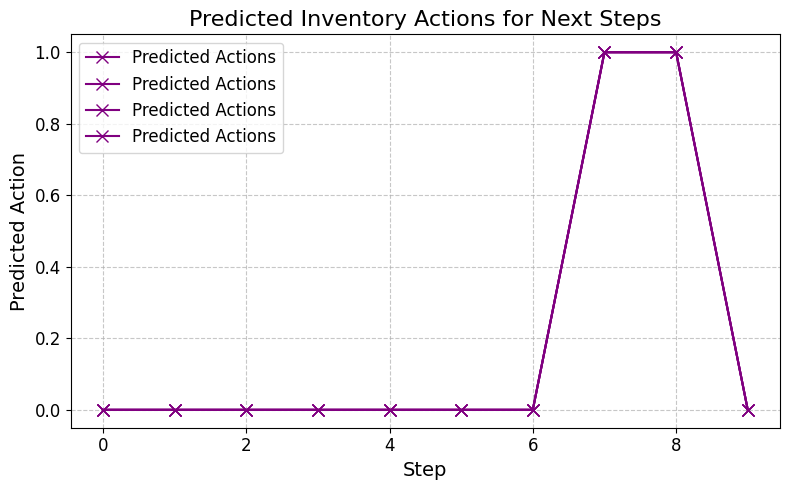

Predicted Inventory Actions for Next Steps:
Step 1: Action - [0 0 0 0]
Step 2: Action - [0 0 0 0]
Step 3: Action - [0 0 0 0]
Step 4: Action - [0 0 0 0]
Step 5: Action - [0 0 0 0]
Step 6: Action - [0 0 0 0]
Step 7: Action - [0 0 0 0]
Step 8: Action - [1 1 1 1]
Step 9: Action - [1 1 1 1]
Step 10: Action - [0 0 0 0]


In [ ]:
def predict_inventory(model, env, initial_observation, num_steps=10):
    obs = initial_observation
    predictions = []

    for step in range(num_steps):
        action, _states = model.predict(obs, deterministic=True)
        predictions.append(action)


        obs, reward, done, info = env.step(action)


        if done.any():
            for idx in range(len(done)):
                if done[idx]:
                    obs[idx] = env.reset()[idx]

    return predictions


initial_obs = env.reset()
predicted_actions = predict_inventory(dqn_model, env, initial_obs, num_steps=10)


plt.figure(figsize=(8, 5))
plt.plot(predicted_actions, marker='x', color='purple', linestyle='-', markersize=8, label='Predicted Actions')
plt.title('Predicted Inventory Actions for Next Steps', fontsize=16)
plt.xlabel('Step', fontsize=14)
plt.ylabel('Predicted Action', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print("Predicted Inventory Actions for Next Steps:")
for i, action in enumerate(predicted_actions):
    print(f"Step {i+1}: Action - {action}")


In [ ]:
import numpy as np
import pandas as pd

item_names = ['Item A', 'Item B', 'Item C', 'Item D']
current_inventory = np.array([20, 10, 30, 5])


inventory_df = pd.DataFrame({
    'Item': item_names,
    'Current Inventory': current_inventory,
    'Predicted Inventory': predicted_actions,
})


restock_threshold = 10
restock_amount = 5

def evaluate_inventory(inventory_df, restock_threshold, restock_amount):
    inventory_df['Action'] = np.where(
        inventory_df['Predicted Inventory'] < restock_threshold,
        f'Restock by {restock_amount}',
        'No Action Needed'
    )
    return inventory_df


updated_inventory_df = evaluate_inventory(inventory_df, restock_threshold, restock_amount)

print("Inventory Recommendations Based on Predictions:")
print(updated_inventory_df)


Inventory Recommendations Based on Predictions:
     Item  Current Inventory  Predicted Inventory            Action
0  Item A                 20                   15  No Action Needed
1  Item B                 10                   25  No Action Needed
2  Item C                 30                   20  No Action Needed
3  Item D                  5                   10  No Action Needed
